In [1]:
generated_story = "In the bustling city of Turboville, a humble mechanic named Jack dreams of winning the prestigious annual car race.\nOn the day of the race, Jack's car breaks down but a mysterious stranger lends a helping hand, fixing his car just intime.\nJack, with his newly repaired car, not only finishes the race but wins it, proving that with a little help, dreams can come true."

In [2]:
stories = generated_story.split("\n")

In [3]:
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

#@markdown **Environment Setup**
import subprocess, time, gc, os, sys


import argparse

NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192 MiB, 7652 MiB


In [4]:
try:
    ipy = get_ipython()
except:
    ipy = 'could not get_ipython'

if 'google.colab' in str(ipy):
    start_time = time.time()
    packages = [
        'https://download.pytorch.org/whl/cu118/xformers-0.0.22.post4%2Bcu118-cp310-cp310-manylinux2014_x86_64.whl',
        'einops==0.4.1 pytorch-lightning==1.7.7 torchdiffeq==0.2.3 torchsde==0.2.5',
        'ftfy timm transformers open-clip-torch omegaconf torchmetrics==0.11.4',
        'safetensors kornia accelerate jsonmerge matplotlib resize-right',
        'scikit-learn numpngw pydantic'
    ]
    for package in packages:
        print(f"..installing {package}")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + package.split())
    if not os.path.exists("deforum-stable-diffusion"):
        subprocess.check_call(['git', 'clone', '-b', '0.7.1', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
    else:
        print(f"..deforum-stable-diffusion already exists")
    with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
        f.write('')
    sys.path.extend(['deforum-stable-diffusion/','deforum-stable-diffusion/src',])
    end_time = time.time()
    print(f"..environment set up in {end_time-start_time:.0f} seconds")
else:
    sys.path.extend(['src'])
    print("..skipping setup")

..skipping setup


In [46]:
import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts

In [6]:
def PathSetup():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())
root.models_path, root.output_path = get_model_output_paths(root)

models_path: C:\Users\devan\Documents\pythonPractice\finalfinalfinal-20231022T042643Z-001\finalfinalfinal\models
output_path: C:\Users\devan\Documents\pythonPractice\finalfinalfinal-20231022T042643Z-001\finalfinalfinal\outputs


In [7]:
def ModelSetup():
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "Protogen_V2.2.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root.__dict__.update(ModelSetup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)


config_path: C:\Users\devan\Documents\pythonPractice\finalfinalfinal-20231022T042643Z-001\finalfinalfinal\configs\v1-inference.yaml
ckpt_path: C:\Users\devan\Documents\pythonPractice\finalfinalfinal-20231022T042643Z-001\finalfinalfinal\models\Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


In [10]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '2D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 50 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(0.99)"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(0)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.5)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.5#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 20 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [12]:
max_frames = 50


In [13]:
neg_prompts = {
    #0: "mountain and forest",
}

In [14]:
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}


In [15]:
def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 20 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 5 #@param
    n_samples = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.65 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.01 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast' 
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

In [34]:
args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

In [35]:
if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

In [18]:
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

In [36]:
if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

In [37]:
if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

In [38]:
# critical part
cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()

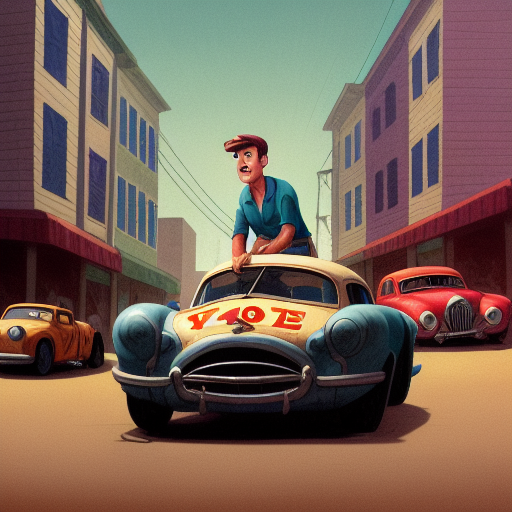

Seed set to 968160266


Rendering animation frame 12 of 50
seed: 968160266
cond_prompt: On the day of the race, Jack's car breaks down but a mysterious stranger lends a helping hand, fixing his car just intime.
uncond_prompt: 
Sampler: euler_ancestral
Angle: 0.0 Zoom: 0.99
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0
noise:  0.02
Strength:  0.65
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.5
Threshold:  0.0
tenc: 7


 43%|█████████████████████▊                             | 3/7 [00:01<00:02,  1.51it/s]


KeyboardInterrupt: 

In [39]:
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

In [75]:
from flask import Flask, request, Response
from  flask_cors  import CORS,  cross_origin

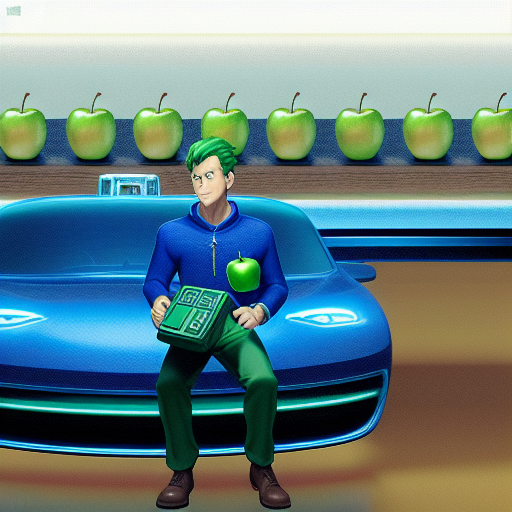

127.0.0.1 - - [22/Oct/2023 06:51:54] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:51:54] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:51:57] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:52:00] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:52:00] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:52:03] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:52:06] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:52:06] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:52:09] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:18] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:53:18] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:20] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:22] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:25] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:53:25] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:27] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:29] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:32] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:53:32] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:35] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:38] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:53:38] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:41] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 06:53:43] "OPTIONS /text_to_images HTTP/1.1" 200 -
127.0.0.1 - - [22/Oct/2023 06:53:43] "POST /text_to_images HTTP/1.1" 200 -


20231022064740_00049.png


127.0.0.1 - - [22/Oct/2023 07:02:41] "POST /terra_data HTTP/1.1" 404 -
127.0.0.1 - - [22/Oct/2023 07:18:34] "POST /terra_data HTTP/1.1" 404 -


In [ ]:
app  = Flask(__name__)

cors = CORS(app)
app.config['CORS_HEADERS'] = 'Content-Type'    

@cross_origin()
@app.route("/text_to_images", methods = ["GET",  "POST"])
def ret_img():
    global file_count
    global t1
    path = "C:/Users/devan/Documents/pythonPractice/finalfinalfinal-20231022T042643Z-001/finalfinalfinal/outputs/2023-10/StableFun"
    dic = request.get_json()
    start = dic["start"]
    if start and not (type(t1) != type(None) and t1.is_alive()):
        file_count = len(os.listdir(path))
        t1 = threading.Thread(target=gen_start, args=(dic["Text"],))
        t1.start()
        return Response(status = 200)
    else:
        if (len(os.listdir(path)) == file_count):
            return {"img": False}
        else:
            most_recent = newest_file_in_directory(path)
            print(most_recent)
            if type(most_recent) == type(None):
                return {"img": False}
#             print(most_recent)
            img = Image.open(path +  "/" + most_recent)
            img_str  = PIL_to_encode(img).decode()
#             print(img_str)
            out = {"img": True, "data": img_str}
            return out
        
@app.route("/data", methods = ["GET", "POST"])
@cross_origin()
def send_mind_data():
    dic = request.get_json()
    idx = dic["item_idx"]
    if not 1<=idx<=10:
        return Response(status = 489)
    out = get_images(idx)
    return out

@app.route("/text_to_story", methods = ["GET",  "POST"])
def text_to_story():
    dic  = request.get_json()
    arr = dic["data"]
    story = generate_story(arr)
    return story
        
app.run(port=5000)
        

In [89]:
from PIL import Image

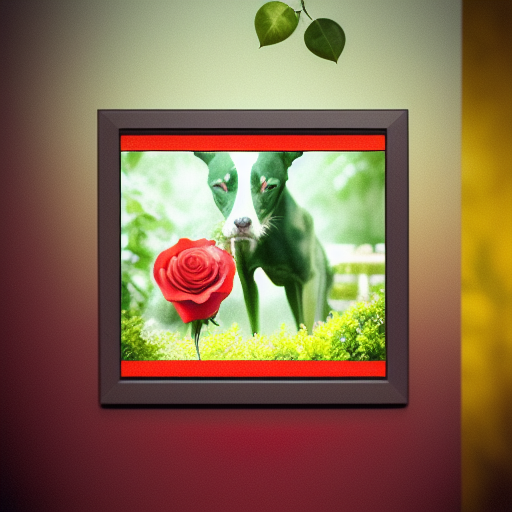

KeyboardInterrupt: 

In [150]:
t1.join()

In [81]:
file_count = 0

In [148]:
import threading

most_recent = ""
path = "C:/Users/devan/Documents/pythonPractice/finalfinalfinal-20231022T042643Z-001/finalfinalfinal/outputs/2023-10/StableFun"


def gen_start(text = ""):
    args_dict = DeforumArgs()
    anim_args_dict = DeforumAnimArgs()
    
    if override_settings_with_file:
        load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

    args = SimpleNamespace(**args_dict)
    anim_args = SimpleNamespace(**anim_args_dict)

    args.timestring = time.strftime('%Y%m%d%H%M%S')
    args.strength = max(0.0, min(1.0, args.strength))
    
    if args.seed == -1:
        args.seed = random.randint(0, 2**32 - 1)
    if not args.use_init:
        args.init_image = None
    if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
        print(f"Init images aren't supported with PLMS yet, switching to KLMS")
        args.sampler = 'klms'
    if args.sampler != 'ddim':
        args.ddim_eta = 0

    if anim_args.animation_mode == 'None':
        anim_args.max_frames = 1
    elif anim_args.animation_mode == 'Video Input':
        args.use_init = True

    if text == "":
        text = "In the bustling city of Turboville, a humble mechanic named Jack dreams of winning the prestigious annual car race.\nOn the day of the race, Jack's car breaks down but a mysterious stranger lends a helping hand, fixing his car just intime.\nJack, with his newly repaired car, not only finishes the race but wins it, proving that with a little help, dreams can come true."
    stories = text.split("\n")
    prompts = {i * max_frames//(len(stories)+1): stories[i] for i in range(len(stories))}
    cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()
    if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
        det =  render_animation(root, anim_args, args, cond, uncond)
    elif anim_args.animation_mode == 'Video Input':
        render_input_video(root, anim_args, args, cond, uncond)
    elif anim_args.animation_mode == 'Interpolation':
        render_interpolation(root, anim_args, args, cond, uncond)
    else:
        render_image_batch(root, args, cond, uncond)


In [67]:
import base64
from io import BytesIO

def PIL_to_encode(image):
    
    if image.mode == 'RGBA':
        # Convert the image into RGB
        rgb_image = Image.new("RGB", image.size, (255, 255, 255))  # White background
        rgb_image.paste(image, mask=image.split()[3])  # Paste the image using the alpha channel as a mask
        image = rgb_image
    
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str


In [53]:
def newest_file_in_directory(directory):
    # List all files in directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Return None if there are no files
    if not files:
        return None
    
    # Find the newest file based on modification time
    newest_file = max(files, key=lambda f: os.path.getmtime(os.path.join(directory, f)))
    
    return newest_file

In [78]:
import sys

In [129]:
sys.exit()

SystemExit: 

C:\Users\devan\anaconda3\envs\vid_gen\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [105]:
import base64
from io import BytesIO

def PIL_to_encode(image):
    
    if image.mode == 'RGBA':
        # Convert the image into RGB
        rgb_image = Image.new("RGB", image.size, (255, 255, 255))  # White background
        rgb_image.paste(image, mask=image.split()[3])  # Paste the image using the alpha channel as a mask
        image = rgb_image
    
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str

def get_images(idx):
    data = {}
    im_path, embed_path, desc_path = pick_image(idx)
    print(im_path, embed_path, desc_path)
    embed_img = visualize_embed(embed_path)
    eeg_image = eeg_vis()
    gen_img = Image.open(im_path)
    text_desc = ""
    with open(desc_path, "r") as f:
        text_desc = f.read()
    data["gen_img"] = PIL_to_encode(gen_img).decode()
    data["eeg_img"] = PIL_to_encode(eeg_image).decode()
    data["embed_img"] = PIL_to_encode(embed_img).decode()
    data["desc"] = text_desc
    return data 
get_images(1)
    

C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_144.jpg C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_144_eeg.npy C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_144_desc.txt


NameError: name 'visualize_embed' is not defined

In [154]:
import os
import random
import colorsys
idx_to_name = {1: "apple", 2: "blue car", 3: "dog", 4: "flower", 5: "gold bracelet", 6: "phone", 7: "scooter", 8: "tiger", 9: "wallet", 10: "watches"}
name_to_idx = {j:i for (i,j) in idx_to_name.items()}
path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered"
direc = os.listdir(path)
rel_files = {}
for name in direc:
    true_img_path = path + f'/{name}/true_image.jpg'
    rel_files[name] = list(filter(lambda x: x[-4:] == ".jpg", os.listdir(path + f'/{name}')))
    
    
    
def pick_image(idx = 1):
    path = "C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered"
    img_name = random.choice(rel_files[idx_to_name[idx]])[:-4]
    eeg_name = img_name + "_eeg"
    desc_name  = img_name + "_desc" 
    img_path =  path + f"/{idx_to_name[idx]}/" + img_name + ".jpg"
    eeg_path = path + f"/{idx_to_name[idx]}/" + eeg_name + ".npy"
    desc_path = path + f"/{idx_to_name[idx]}/" + desc_name + ".txt"
    
    return img_path, eeg_path, desc_path

In [124]:
def visualize_embed(file_path = None, eeg_data = None):
    buf = io.BytesIO() 
    # Load the data
    print(file_path)
    if type(eeg_data) == type(None): 
        eeg_data = np.load(file_path)
    # Time vector (assuming a common EEG sampling rate of 256 Hz)
    time = np.linspace(0, len(eeg_data) / 256, len(eeg_data))
    
    # Set font properties for a more formal appearance
    font_properties = {
        'family': 'serif',
        'weight': 'normal',
        'size': 12
    }

    # Plotting the EEG data with updated font properties
    plt.figure(figsize=(10, 5))
    plt.plot(time, eeg_data)
    plt.xlabel('Time (seconds)', fontdict=font_properties)
    plt.ylabel('EEG Amplitude', fontdict=font_properties)
    plt.title('EEG Data Visualization', fontdict={'family': 'serif', 'weight': 'bold', 'size': 14})
    plt.grid(True)
    plt.tight_layout()

    # Update tick labels font
    plt.xticks(fontname='serif')
    plt.yticks(fontname='serif')

    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img

# Test the function with the provided EEG data file
# visualize_embed("C:/Users/devan/Documents/pythonPractice/EEG2Image/data/filtered/apple/0_79_eeg.npy")


In [125]:
import io
import numpy as np
import matplotlib.pyplot as plt

def eeg_vis(r = -1):
    buf = io.BytesIO() 
    plt.rcParams["font.family"] = "Times New Roman"
    if r == -1:
        r = random.choice(range(45000))
    eeg_data = np.load(f'C:/Users/devan/Documents/pythonPractice/EEG2Image/data/misc_eeg/{r}.npy')
    plt.figure(figsize=(15, 10))
    plt.style.use('seaborn-v0_8-whitegrid')
    # Shades of green
    green_shades = green_shades = ['#002800','#003C00','#005000','#006400', '#2E8B57', '#228B22', '#556B2F', '#6B8E23', '#3CB371', '#20B2AA', '#32CD32', '#66CDAA', '#9ACD32', '#8FBC8F']
    def darken_color(rgb_color, factor=0.9):
        r, g, b = rgb_color
        h, l, s = colorsys.rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
        l = max(0, min(1, l * factor))
        r, g, b = colorsys.hls_to_rgb(h, l, s)
        return r, g, b
    # Convert hex to RGB and then darken the color
    green_shades = [darken_color(tuple(int(col[i:i+2], 16) for i in (1, 3, 5))) for col in green_shades]
    for i in range(14):
        plt.plot(eeg_data[i, :, 0], color=green_shades[i], label=f"Channel {i+1}")
    plt.title("EEG Data for 14 Channels", fontsize=20, fontweight='bold')
    plt.xlabel("Time Points", fontsize=18)
    plt.ylabel("Amplitude", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc="upper right", fontsize=12, frameon=True, title="Channels", title_fontsize=14, facecolor='white', edgecolor='black')
    plt.tight_layout()
    plt.savefig(buf, format='png')

    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img

# eeg_vis()

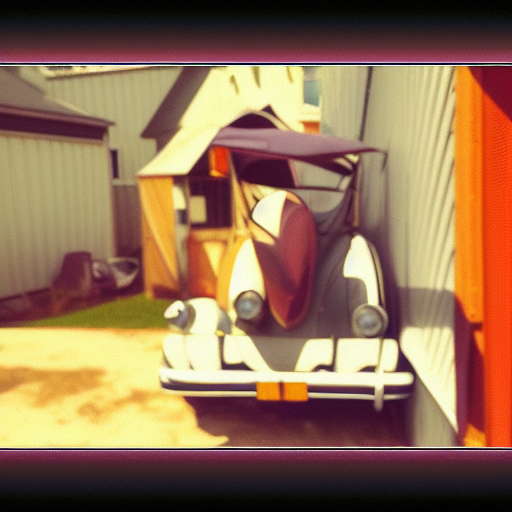

Seed set to 996892853


Rendering animation frame 29 of 50
seed: 996892853
cond_prompt:  The car is parked in the yard
uncond_prompt: 
Sampler: euler_ancestral
Angle: 0.0 Zoom: 0.99
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0
noise:  0.02
Strength:  0.65
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.5
Threshold:  0.0
tenc: 7


  0%|                                                           | 0/7 [00:00<?, ?it/s]

In [139]:
import json 
import openai

with open('openai_api.json', 'r') as file:
    api_keys = json.load(file)
    openai.api_key = api_keys.get("OPENAI_API_KEY")

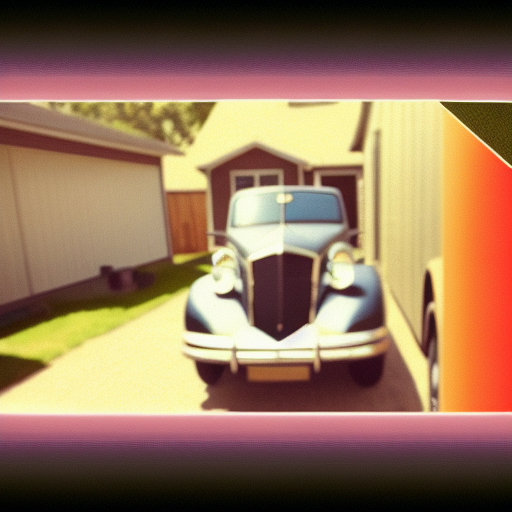

Seed set to 996892871


Rendering animation frame 47 of 50
seed: 996892871
cond_prompt:  The car is parked in the yard
uncond_prompt: 
Sampler: euler_ancestral
Angle: 0.0 Zoom: 0.99
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0
noise:  0.02
Strength:  0.65
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.5
Threshold:  0.0
tenc: 7


 71%|████████████████████████████████████▍              | 5/7 [00:02<00:01,  1.67it/s]

In [142]:
def generate_story(input_strings):
    # Prepare an advanced prompt for the OpenAI model based on the input strings
    elements = ", ".join(input_strings)
    prompt = (
        f"Create a simple story suitable for text-to-video conversion, including the following elements: {elements}. "
        "The story should have a clear beginning, middle, and end. "
        "Begin with an introduction of the setting and characters, followed by a problem, and then resolve the problem in the end. "
        "Make it short and 3 lines long. Print each of the three lines in a new line. "
    )

    # Use OpenAI to generate a continuation of the prompt
    response = openai.ChatCompletion.create(
        model="gpt-4",  # Use "gpt-4" if available, otherwise use "gpt-3.5-turbo"
        messages=[{"role": "system", "content": "You are a helpful assistant."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=300
    )

    story = response['choices'][0]['message']['content'].strip()
    return story

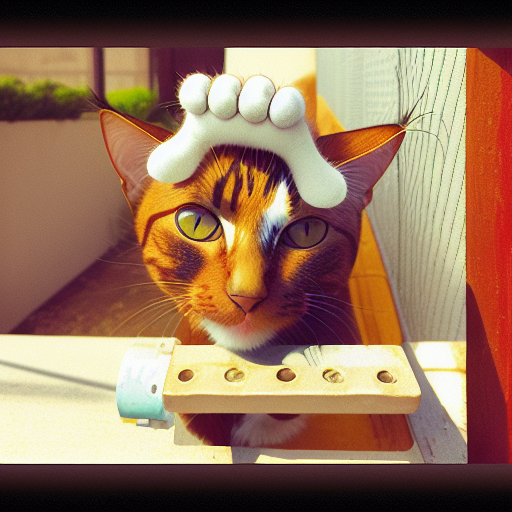

Seed set to 996892845


Rendering animation frame 21 of 50
seed: 996892845
cond_prompt:  The cat jumped over the fence 
uncond_prompt: 
Sampler: euler_ancestral
Angle: 0.0 Zoom: 0.99
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0
noise:  0.02
Strength:  0.65
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.5
Threshold:  0.0
tenc: 7


 29%|██████████████▌                                    | 2/7 [00:01<00:02,  1.69it/s]

In [137]:
sys.exit()

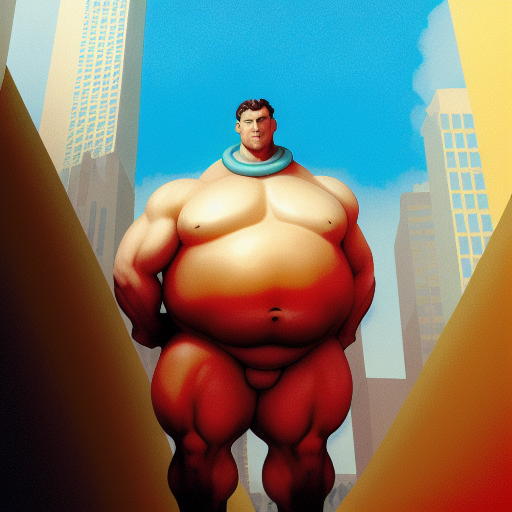

Seed set to 2605043572


Rendering animation frame 30 of 50
seed: 2605043572
cond_prompt: With a gentle massage on his neck and shoulders, the city's masseuse solved the problem, restoring peace and the giant's mobility.
uncond_prompt: 
Sampler: euler_ancestral
Angle: 0.0 Zoom: 0.99
Tx: 0.0 Ty: 0.0 Tz: 0.0
Rx: 0.0 Ry: 0.0 Rz: 0.0
noise:  0.02
Strength:  0.65
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.5
Threshold:  0.0
tenc: 7


100%|███████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.71it/s]


In [146]:
len(os.listdir(path))